In [1]:
import re
import numpy as np
import sys
import time
d_corpus = sc.textFile("../data/SmallTrainingData.txt", 1)
d_keyAndText = d_corpus.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:][:-6]))
regex = re.compile('[^a-zA-Z]')
d_keyAndListOfWords = d_keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))

In [2]:
allWords = d_keyAndListOfWords.flatMap(lambda x: x[1]).map(lambda x: (x, 1))
from operator import add
allCounts = allWords.reduceByKey(add)

In [3]:
topWords = allCounts.top(20000, key=lambda x: x[1])
twentyK = sc.parallelize(range(20000))

In [4]:
dictionary = twentyK.map (lambda x : (topWords[x][0], x))

In [5]:
def buildArray (listOfIndices):
    returnVal = np.zeros (20000)
    for index in listOfIndices:
        returnVal[index] = returnVal[index] + 1
    mysum = np.sum (returnVal)
    returnVal = np.divide (returnVal, mysum)
    return returnVal

In [6]:
allWords = d_keyAndListOfWords.flatMap(lambda x: ((j, x[0]) for j in x[1]))

In [7]:
allDictionaryWords = dictionary.join(allWords)

In [8]:
justDocAndPos = allDictionaryWords.map(lambda x: (x[1][1], x[1][0]))

In [9]:
allDictionaryWordsInEachDoc = justDocAndPos.groupByKey()

In [10]:
forCSV= allDictionaryWordsInEachDoc.mapValues(lambda x: np.array( list(x)))

In [11]:
tfs = allDictionaryWordsInEachDoc.map(lambda x: (x[0], buildArray(x[1])))

In [12]:
tfs.take(5)

[('AU35',
  array([0.11425061, 0.06511057, 0.02272727, ..., 0.        , 0.        ,
         0.        ])),
 ('AU85',
  array([0.11214496, 0.0553379 , 0.03770813, ..., 0.        , 0.        ,
         0.        ])),
 ('AU160',
  array([0.08426966, 0.04283708, 0.02457865, ..., 0.        , 0.        ,
         0.        ])),
 ('AU561',
  array([0.09657795, 0.03802281, 0.01977186, ..., 0.        , 0.        ,
         0.        ])),
 ('AU736',
  array([0.11322314, 0.0446281 , 0.01983471, ..., 0.        , 0.        ,
         0.        ]))]

In [13]:
def oneHotEncoding(ID):
    if re.compile('^AU').match(ID):
        return 1
    else:
        return 0

In [14]:
data = tfs.map(lambda x: (oneHotEncoding(x[0]), x[1]))

In [15]:
data.take(5)

[(1, array([0.11425061, 0.06511057, 0.02272727, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.11214496, 0.0553379 , 0.03770813, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.08426966, 0.04283708, 0.02457865, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.09657795, 0.03802281, 0.01977186, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.11322314, 0.0446281 , 0.01983471, ..., 0.        , 0.        ,
         0.        ]))]

In [16]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

In [17]:
dataLabel = data.map(lambda x: LabeledPoint(x[0], x[1]))

In [18]:
lrm = LogisticRegressionWithLBFGS.train(dataLabel, iterations=100)

In [19]:
test_corpus = sc.textFile("../data/TestingData.txt", 1)
test_keyAndText = test_corpus.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:][:-6]))
regex = re.compile('[^a-zA-Z]')
test_keyAndListOfWords = test_keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))
test_allWords = test_keyAndListOfWords.flatMap(lambda x: ((j, x[0]) for j in x[1]))
test_allDictionaryWords = dictionary.join(test_allWords)
test_justDocAndPos = test_allDictionaryWords.map(lambda x: (x[1][1], x[1][0]))
test_allDictionaryWordsInEachDoc = test_justDocAndPos.groupByKey()
test_tfs = test_allDictionaryWordsInEachDoc.map(lambda x: (x[0], buildArray(x[1])))
test = test_tfs.map(lambda x: (oneHotEncoding(x[0]), x[1], x[0]))

In [20]:
#testX = test.map(lambda x:x[1])

In [21]:
predTrue = test.map(lambda x: (x[0], lrm.predict(x[1])))

In [22]:
predTrue.take(5)

[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]

In [23]:
def getType1AndType2(true, pred):
    if true == 1.0 and pred == 1.0:
        TP = 1.0
    else:
        TP = 0.0
    if true == 0.0 and pred == 0.0:
        TN = 1.0
    else:
        TN = 0.0
    if true == 1.0 and pred == 0.0:
        FN = 1.0
    else:
        FN = 0.0
    if true == 0.0 and pred == 1.0:
        FP = 1.0
    else:
        FP = 0.0
    
    return np.array([TP, TN, FN, FP])

In [24]:
type1AndType2 = predTrue.map(lambda x: getType1AndType2(x[0], x[1]))
matric = type1AndType2.map(lambda x: (1, x)).reduceByKey(lambda x1, x2: np.add(x1, x2)).collect()

In [25]:
TP = matric[0][1][0]
TN = matric[0][1][1]
FN = matric[0][1][2]
FP = matric[0][1][3]

In [26]:
def getF1score(TP, TN, FN, FP):
    if TP == 0:
        return 0
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = 2 * (precision * recall) / (precision + recall)
    return f_score

In [27]:
f1_score = getF1score(TP, TN, FN, FP)

In [28]:
TP

349.0

In [29]:
TN

18338.0

In [30]:
FN

28.0

In [31]:
FP

9.0

In [32]:
print(f1_score)

0.9496598639455782


In [33]:
# task2

In [51]:
import numpy as np

In [52]:
scores = np.array([[1,2], [3,4], [5, 6], [7, 8]])
yi_scores = scores[np.arange(scores.shape[0]), [0, 1, 0, 1]]

In [53]:
yi_scores

array([1, 4, 5, 8])

In [54]:
margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)

In [55]:
np.maximum(0, scores - np.matrix(yi_scores).T + 1)

matrix([[1, 2],
        [0, 1],
        [1, 2],
        [0, 1]])

In [56]:
num_train = scores.shape[0]
y = [0, 1, 0, 1]
margins[np.arange(num_train),y] = 0

In [57]:
margins

matrix([[0, 2],
        [0, 0],
        [0, 2],
        [0, 0]])

In [58]:
np.sum(margins, axis=1)

matrix([[2],
        [0],
        [2],
        [0]])

In [59]:
loss = np.mean(np.sum(margins, axis=1))
loss

1.0

In [60]:
binary = margins
binary[margins > 0] = 1
binary

matrix([[0, 1],
        [0, 0],
        [0, 1],
        [0, 0]])

In [61]:
row_sum = np.sum(binary, axis=1)
row_sum

matrix([[1],
        [0],
        [1],
        [0]])

In [62]:
binary[np.arange(num_train), y] = -row_sum.T

In [63]:
binary

matrix([[-1,  1],
        [ 0,  0],
        [-1,  1],
        [ 0,  0]])

In [64]:
def getPreMargin(scores, yi_scores):
    # max(0, xw - xw_true) + delta
    return np.maximum(0.0, np.subtract(scores, yi_scores) + 1)

In [65]:
def changeToZero(preMargins, y):
    preMargins[y] = 0.0
    return preMargins

In [66]:
# Set initial weights (200000, 2)
W = np.full((20000, 2), 0.1)
# Set initial dW as zero
dW = np.zeros(W.shape)
# To get scores do dot product of X (n, 200000) and W (200000, 2)
scores = data.map(lambda x: (x[0], x[1], np.dot(x[1], W)))
# Select one correctly categorized point.
yi_scores = scores.map(lambda x: (x[0], x[1], x[2], x[2][x[0]]))
# Calculate margin and ignore the correctlly classified points by setting them 0.
preMargins = yi_scores.map(lambda x: (x[0], x[1], getPreMargin(x[2], x[3])))
margins = preMargins.map(lambda x: (x[0], x[1], changeToZero(x[2], x[0])))
# Calculate loss by taking mean of distance from mergin to point
loss = margins.map(lambda x: (1, (np.sum(x[2]), 1.0)))\
            .reduceByKey(lambda x1, x2: (x1[0] + x2[0], x1[1] + x2[1]))
loss = loss.collect()[0][1]
loss = loss[0] / loss[1]

In [67]:
loss

1.0

In [68]:
def getBinary(margins):
    margins[margins > 0.0] = 1.0
    return margins

In [69]:
def changeToRowSum(binary, y, row_sum):
    binary[y] = - row_sum
    return binary

In [70]:
def getDw(x, b):
    return np.array([x * b[0], x * b[1]])

In [71]:
num_train = data.count()

In [72]:
num_train

3442

In [73]:
binary = margins.map(lambda x: (x[0], x[1], getBinary(x[2])))
row_sum = binary.map(lambda x: (x[0], x[1], x[2], np.sum(x[2])))
trueBinary = row_sum.map(lambda x: (x[0], x[1], changeToRowSum(x[2], x[0], x[3])))
dW = trueBinary.map(lambda x: (1,  getDw(x[1], x[2])))\
                .reduceByKey(lambda x1, x2: np.add(x1, x2))
dW = dW.collect()[0][1].reshape(-1, 2)
# Average
dW /= num_train
dW += reg * W

NameError: name 'reg' is not defined

In [74]:
def svm_loss(W, reg):
    # Set initial dW as zero
    dW = np.zeros(W.shape)
    # To get scores do dot product of X (n, 200000) and W (200000, 2)
    scores = data.map(lambda x: (x[0], x[1], np.dot(x[1], W)))
    # Select one correctly categorized point.
    yi_scores = scores.map(lambda x: (x[0], x[1], x[2], x[2][x[0]]))
    # Calculate margin and ignore the correctlly classified points by setting them 0.
    preMargins = yi_scores.map(lambda x: (x[0], x[1], getPreMargin(x[2], x[3])))
    margins = preMargins.map(lambda x: (x[0], x[1], changeToZero(x[2], x[0])))
    # Calculate loss by taking mean of distance from mergin to point
    loss = margins.map(lambda x: (1, (np.sum(x[2]), 1.0)))\
                .reduceByKey(lambda x1, x2: (x1[0] + x2[0], x1[1] + x2[1]))
    loss = loss.collect()[0][1]
    loss = loss[0] / loss[1]
    # Set binary by setting one if the distance from margin is over than zero.
    binary = margins.map(lambda x: (x[0], x[1], getBinary(x[2])))
    # Set the correctly classified case to negative one or zero
    row_sum = binary.map(lambda x: (x[0], x[1], x[2], np.sum(x[2])))
    trueBinary = row_sum.map(lambda x: (x[0], x[1], changeToRowSum(x[2], x[0], x[3])))
    # Get derivative of yx part, if j = yi, -x, otherwise x 
    dW = trueBinary.map(lambda x: (1,  getDw(x[1], x[2])))\
                    .reduceByKey(lambda x1, x2: np.add(x1, x2))
    dW = dW.collect()[0][1].reshape(-1, 2)
    # Average
    dW /= num_train
    dW += reg * W
    
    return loss, dW

In [75]:
# Set initial weights (200000, 2)
W = np.full((20000, 2), 0.1)
num_iteration = 100
learningRate = 0.01
count = 0
reg = 0.1
loss_prev =  sys.float_info.max
while num_iteration > count:
    
    loss, dW = svm_loss(W, reg)
    
    W = np.subtract(W, learningRate*dW)
    
    # Bold Driver logic
    if loss < loss_prev:
        learningRate *= 1.05
    else:
        learningRate *= 0.5

    print("Iteration: ", count)
    print("W: " ,W)
    print("Loss: ", loss)
    
    loss_prev = loss

    count += 1

Iteration:  0
W:  [[0.1006494  0.10024987]
 [0.10021753 0.10018294]
 [0.10013093 0.10011759]
 ...
 [0.09989999 0.09989996]
 [0.09989998 0.09989993]
 [0.09989994 0.09989997]]
Loss:  1.0
Iteration:  1
W:  [[0.10133059 0.10051196]
 [0.1004457  0.10037484]
 [0.10026827 0.10024094]
 ...
 [0.09979507 0.09979501]
 [0.09979506 0.09979496]
 [0.09979499 0.09979505]]
Loss:  0.9999674847654674
Iteration:  2
W:  [[0.10204509 0.10078687]
 [0.10068504 0.10057612]
 [0.10041233 0.10037031]
 ...
 [0.09968503 0.09968494]
 [0.09968501 0.09968487]
 [0.0996849  0.09968499]]
Loss:  0.9999333779102058
Iteration:  3
W:  [[0.10279449 0.10107521]
 [0.10093606 0.10078724]
 [0.10056342 0.10050601]
 ...
 [0.09956962 0.09956949]
 [0.09956958 0.09956939]
 [0.09956944 0.09956956]]
Loss:  0.9998976033149879
Iteration:  4
W:  [[0.10358045 0.10137762]
 [0.10119933 0.10100865]
 [0.10072189 0.10064832]
 ...
 [0.09944857 0.09944841]
 [0.09944852 0.09944828]
 [0.09944835 0.0994485 ]]
Loss:  0.9998600814035756
Iteration:  5
W

Iteration:  41
W:  [[0.1823052  0.1316679 ]
 [0.12756939 0.12318625]
 [0.11659433 0.11490327]
 ...
 [0.08732413 0.08732039]
 [0.08732299 0.08731736]
 [0.08731892 0.08732245]]
Loss:  0.9960904783804411
Iteration:  42
W:  [[0.18670678 0.13336146]
 [0.12904377 0.12442622]
 [0.11748177 0.11570028]
 ...
 [0.08664624 0.0866423 ]
 [0.08664503 0.0866391 ]
 [0.08664075 0.08664447]]
Loss:  0.9958790252896351
Iteration:  43
W:  [[0.19129256 0.1351259 ]
 [0.13057985 0.12571809]
 [0.11840635 0.11653064]
 ...
 [0.08593998 0.08593583]
 [0.08593871 0.08593247]
 [0.08593421 0.08593811]]
Loss:  0.9956586407559662
Iteration:  44
W:  [[0.1960684  0.13696346]
 [0.13217958 0.12706349]
 [0.11936926 0.11739542]
 ...
 [0.08520446 0.08520009]
 [0.08520312 0.08519655]
 [0.08519837 0.08520249]]
Loss:  0.9954290330561606
Iteration:  45
W:  [[0.20104011 0.13887638]
 [0.13384494 0.12846408]
 [0.12037165 0.11829567]
 ...
 [0.08443876 0.08443417]
 [0.08443735 0.08443044]
 [0.08443236 0.08443669]]
Loss:  0.995189909758

Iteration:  82
W:  [[0.54252735 0.27026766]
 [0.24823133 0.22466467]
 [0.18922211 0.18012988]
 ...
 [0.03184613 0.03182601]
 [0.03183996 0.03180969]
 [0.03181812 0.03183706]]
Loss:  0.9784416039173948
Iteration:  83
W:  [[0.55439653 0.27483447]
 [0.2522071  0.22800835]
 [0.19161517 0.18227908]
 ...
 [0.03001815 0.02999749]
 [0.03001181 0.02998074]
 [0.02998939 0.03000884]]
Loss:  0.9778429059522364
Iteration:  84
W:  [[0.56614415 0.27935451]
 [0.25614214 0.23131778]
 [0.19398372 0.18440626]
 ...
 [0.02820889 0.0281877 ]
 [0.02820239 0.02817051]
 [0.02817938 0.02819934]]
Loss:  0.9772486225243716
Iteration:  85
W:  [[0.57773606 0.28381464]
 [0.26002503 0.23458334]
 [0.19632088 0.18650524]
 ...
 [0.02642362 0.0264019 ]
 [0.02641695 0.02638428]
 [0.02639337 0.02641382]]
Loss:  0.9766604258908194
Iteration:  86
W:  [[0.58913767 0.28820154]
 [0.26384417 0.2377953 ]
 [0.19861966 0.18856977]
 ...
 [0.02466765 0.02464541]
 [0.02466083 0.02462738]
 [0.02463669 0.02465762]]
Loss:  0.976080025423

In [94]:
W_true = W[np.arange(len(W)), np.argmax(W, axis = 1)]


In [95]:
# test_corpus = sc.textFile("../data/TestingData.txt", 1)
# test_keyAndText = test_corpus.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:][:-6]))
# regex = re.compile('[^a-zA-Z]')
# test_keyAndListOfWords = test_keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))

# test_allWords = test_keyAndListOfWords.flatMap(lambda x: ((j, x[0]) for j in x[1]))
# test_allDictionaryWords = dictionary.join(test_allWords)
# test_justDocAndPos = test_allDictionaryWords.map(lambda x: (x[1][1], x[1][0]))
# test_allDictionaryWordsInEachDoc = test_justDocAndPos.groupByKey()
# test_tfs = test_allDictionaryWordsInEachDoc.map(lambda x: (x[0], buildArray(x[1])))
# test = test_tfs.map(lambda x: (oneHotEncoding(x[0]), x[1], x[0]))

In [76]:
prediction = test.map(lambda x: (x[0], np.dot(x[1], W_true), x[2]))\
                 .map(lambda x: (x[0], (1 if x[1] >= 0 else 0), x[2]))
#prediction = test.map(lambda x: (x[0], np.dot(x[1], W), x[2]))
last = data.map()

In [77]:
prediction.take(5)

[(1, array([0.09851369, 0.0634755 ]), 'AU67'),
 (1, array([0.1180555 , 0.07496817]), 'AU87'),
 (1, array([0.09667707, 0.06126231]), 'AU329'),
 (1, array([0.10016351, 0.0650873 ]), 'AU360'),
 (1, array([0.10972493, 0.06955617]), 'AU365')]

In [98]:
def getType1AndType2(true, pred):
    if true == 1 and pred == 1:
        TP = 1.0
    else:
        TP = 0.0
    if true == 0 and pred == 0:
        TN = 1.0
    else:
        TN = 0.0
    if true == 1 and pred == 0:
        FN = 1.0
    else:
        FN = 0.0
    if true == 0 and pred == 1:
        FP = 1.0
    else:
        FP = 0.0
    
    return np.array([TP, TN, FN, FP])

In [99]:
type1AndType2 = prediction.map(lambda x: (x[2], getType1AndType2(x[0], x[1])))
matric = type1AndType2.map(lambda x: (1, x[1])).reduceByKey(lambda x1, x2: np.add(x1, x2)).collect()

In [100]:
type1AndType2.take(5)

[('AU67', array([1., 0., 0., 0.])),
 ('AU87', array([1., 0., 0., 0.])),
 ('AU329', array([1., 0., 0., 0.])),
 ('AU360', array([1., 0., 0., 0.])),
 ('AU365', array([1., 0., 0., 0.]))]

In [101]:
TP = matric[0][1][0]
TN = matric[0][1][1]
FN = matric[0][1][2]
FP = matric[0][1][3]

In [102]:
def getF1score(TP, TN, FN, FP):
    if TP == 0:
        return 0
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = 2 * (precision * recall) / (precision + recall)
    return f_score

In [78]:
f1_score = getF1score(TP, TN, FN, FP)

In [79]:
f1_score

0.9496598639455782

In [105]:
#task 3

In [106]:
data.take(3)

[(1, array([0.11425061, 0.06511057, 0.02272727, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.11214496, 0.0553379 , 0.03770813, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.08426966, 0.04283708, 0.02457865, ..., 0.        , 0.        ,
         0.        ]))]

In [116]:
def getXtX(x):
    return  np.array([np.multiply(x, m) for m in x])

In [122]:
XtX = data.map(lambda x: (1, getXtX(x[1])))\
        .reduceByKey(lambda x1, x2: np.add(x1, x2))

In [123]:
XtX.take(1)

KeyboardInterrupt: 

In [121]:
a = np.arange(20000)
[np.multiply(a, i) for i in a]


[array([0, 0, 0, ..., 0, 0, 0]),
 array([    0,     1,     2, ..., 19997, 19998, 19999]),
 array([    0,     2,     4, ..., 39994, 39996, 39998]),
 array([    0,     3,     6, ..., 59991, 59994, 59997]),
 array([    0,     4,     8, ..., 79988, 79992, 79996]),
 array([    0,     5,    10, ..., 99985, 99990, 99995]),
 array([     0,      6,     12, ..., 119982, 119988, 119994]),
 array([     0,      7,     14, ..., 139979, 139986, 139993]),
 array([     0,      8,     16, ..., 159976, 159984, 159992]),
 array([     0,      9,     18, ..., 179973, 179982, 179991]),
 array([     0,     10,     20, ..., 199970, 199980, 199990]),
 array([     0,     11,     22, ..., 219967, 219978, 219989]),
 array([     0,     12,     24, ..., 239964, 239976, 239988]),
 array([     0,     13,     26, ..., 259961, 259974, 259987]),
 array([     0,     14,     28, ..., 279958, 279972, 279986]),
 array([     0,     15,     30, ..., 299955, 299970, 299985]),
 array([     0,     16,     32, ..., 319952, 319968,

In [81]:
mu = data.map(lambda x: (1, x[1]))\
        .reduceByKey(lambda x1, x2: np.add(x1, x2)).collect()[0][1]
mu = np.divide(mu, num_train)
variance = data.map(lambda x: (1, np.square(np.subtract(x[1], mu))))\
                .reduceByKey(lambda x1, x2: np.add(x1, x2)).collect()[0][1]
variance = np.divide(variance, num_train)

In [93]:
label = [(i, variance[i]) for i in range(len(variance))]

In [98]:
sortedColumn = sorted(label, key = lambda x: x[1], reverse=True)

In [117]:
import matplotlib.pyplot as plt

In [119]:
sortedVariance = np.array([sortedColumn[i][1] for i in range(len(sortedColumn))])

In [120]:
sortedVariance

array([4.36702330e-04, 1.93704438e-04, 1.16623943e-04, ...,
       2.58938400e-10, 1.93133807e-10, 1.93133807e-10])

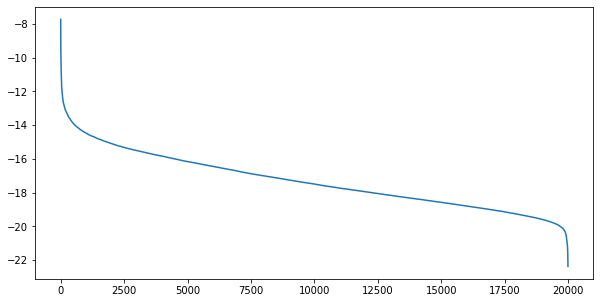

In [124]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(sortedVariance)), np.log(sortedVariance))
plt.show()

In [125]:
topColumn = sortedColumn[:10000]
columnIdx = [topColumn[i][0] for i in range(len(topColumn))]

In [132]:
selectedData = data.map(lambda x: (x[0], x[1][columnIdx]))

In [133]:
selectedData.take(5)

[(1, array([0.11425061, 0.06511057, 0.01781327, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.11214496, 0.0553379 , 0.02546523, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.08426966, 0.04283708, 0.03195225, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.09657795, 0.03802281, 0.02357414, ..., 0.        , 0.        ,
         0.        ])),
 (1, array([0.11322314, 0.0446281 , 0.01404959, ..., 0.        , 0.        ,
         0.        ]))]